---

#NOTICE

This project is not actively maintained and is currently being rewritten as a library. Please refer to [imbalance-baselines](https://github.com/metu-balance/imbalance-baselines) GitHub page for the latest revision.

---

# Training ResNets Using Class-Balanced Loss

Long-tailed CIFAR-10 dataset class was adapted from:

https://github.com/kaidic/LDAM-DRW/blob/master/imbalance_cifar.py

iNaturalist dataset class was adapted from:

https://github.com/macaodha/inat_comp_2018/blob/master/inat2018_loader.py

https://pytorch.org/vision/master/_modules/torchvision/datasets/inaturalist.html

The class-balanced focal loss function was adapted from:

https://github.com/richardaecn/class-balanced-loss/blob/master/src/cifar_main.py#L226-L266

https://github.com/vandit15/Class-balanced-loss-pytorch/blob/master/class_balanced_loss.py

# Initializations & Definitions
Please make the desired initializations and **run the code blocks below before the first run**.

Also, run the initialization block **whenever a change is made**.

In [ ]:
BATCH_SIZE = 128  #@param{type:"integer"}
EPOCH_CNT =   200#@param{type:"integer"}
MULTI_GPU = True  #@param{type:"boolean"}

#@markdown ---

DATASET = "IMB_CIFAR10"  #@param ["CIFAR10", "IMB_CIFAR10", "INATURALIST_2017", "INATURALIST_2018"]
CIFAR_IMB_FACTOR = 50  #@param [10, 20, 50, 100, 200]
INAT_32X32 = False  #@param{type:"boolean"}

DSET_NAMES = {
    "CIFAR10": "CIFAR10",
    "IMB_CIFAR10": "Long-Tailed CIFAR10",
    "INATURALIST_2017": "iNaturalist 2017",
    "INATURALIST_2018": "iNaturalist 2018"
}

RESNET_TYPE = "32"  #@param ["32", "50", "101", "152"]
BETA = 0.9999  #@param{type:"number"}

#@markdown ---

PRINT_TRAINING = True  #@param{type:"boolean"}
PRINT_FREQ =   1#@param{type:"integer"}
DRAW_PLOTS = False  #@param{type:"boolean"}

#@markdown ---

USE_GOOGLE_DRIVE = True  #@param{type:"boolean"}
MODELS_PATH ="/content/drive/MyDrive/Colab Notebooks/cb_loss_resnet/trained_models/"  #@param{type:"string"}
SAVE_MODELS = True  #@param{type:"boolean"}
LOAD_MODELS = False  #@param{type:"boolean"}

#@markdown ---

TRAIN_FOCAL = True  #@param{type:"boolean"}
TRAIN_SIGMOID = True  #@param{type:"boolean"}
TRAIN_SOFTMAX = True  #@param{type:"boolean"}
TRAIN_CB_FOCAL = True  #@param{type:"boolean"}
TRAIN_CB_SIGMOID = True  #@param{type:"boolean"}
TRAIN_CB_SOFTMAX = True  #@param{type:"boolean"}

#@markdown ---
#@markdown (Accept prediction if one of the top ACCURACY_TOP guesses is correct)
ACCURACY_TOP = 1  #@param {type:"slider", min:1, max:9, step:1}
TEST_FOCAL = True  #@param{type:"boolean"}
TEST_SIGMOID = True  #@param{type:"boolean"}
TEST_SOFTMAX = True  #@param{type:"boolean"}
TEST_CB_FOCAL = True  #@param{type:"boolean"}
TEST_CB_SIGMOID = True  #@param{type:"boolean"}
TEST_CB_SOFTMAX = True  #@param{type:"boolean"}

if USE_GOOGLE_DRIVE and not MODELS_PATH.startswith("/content/drive/"):
  raise RuntimeError('MODELS_PATH should start with "/content/drive/"' + \
    ' since USE_GOOGLE_DRIVE is True')

if not USE_GOOGLE_DRIVE and MODELS_PATH.startswith("/content/drive/"):
  print("WARNING: USE_GOOGLE_DRIVE is False but MODELS_PATH starts with",
        '"/content/drive/"')

if LOAD_MODELS: SAVE_MODELS = False

if PRINT_FREQ < 1: PRINT_FREQ = 1

if BETA < 0:
  BETA = 0
elif BETA > 1:
  BETA = 1

ACCURACY_TOP = int(ACCURACY_TOP)
if ACCURACY_TOP < 1:
  ACCURACY_TOP = 1
elif ACCURACY_TOP > 9:
  ACCURACY_TOP = 9

if CIFAR_IMB_FACTOR < 10:
  CIFAR_IMB_FACTOR = 10
elif CIFAR_IMB_FACTOR > 200:
  CIFAR_IMB_FACTOR = 200


In [ ]:
import json
import numpy as np
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from numpy.random import RandomState, SeedSequence, MT19937
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from typing import Any, Callable, Optional, Tuple

if USE_GOOGLE_DRIVE:
  from google.colab import drive
  drive.mount("/content/drive")

if DRAW_PLOTS:
  import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using", torch.cuda.device_count(), "GPU device(s).")
else:
    device = torch.device('cpu')
    MULTI_GPU = False
    print("Using CPU.")

# For debugging:
#torch.autograd.set_detect_anomaly(True)

class CIFAR10LT(datasets.CIFAR10):
  cls_cnt = 10

  def __init__(
    self,
    root: str,
    imb_factor=100,  # largest cls. / smallest cls. sample counts
    train: bool = True,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    download: bool = False
  ) -> None:
    
    super().__init__(
        root,
        train,
        transform,
        target_transform,
        download
    )

    self.rs = RandomState(MT19937(SeedSequence()))

    img_num_list = self.get_img_cnt_per_cls(self.cls_cnt, imb_factor)
    self.generate_imb_data(img_num_list)

  def get_img_cnt_per_cls(self, cls_cnt, imb_factor):
    """Return the image count per class required to create class imbalance.

    Args:
      cls_cnt: Number of classes
      imb_factor: Imbalance factor (Largest / Smallest class sizes)
    """

    img_max = len(self.data) / cls_cnt
    img_cnt_per_cls = []

    for cls_index in range(cls_cnt):
      img_cnt_per_cls.append(int(
          img_max * ((1/imb_factor)**(cls_index / (cls_cnt - 1)))
      ))
    
    return img_cnt_per_cls
  
  def generate_imb_data(self, img_cnt_per_cls):
    new_data = []
    new_targets = []

    targets_np = np.array(self.targets, dtype=np.int64)
    classes = np.unique(targets_np)

    self.cnt_per_cls_dict = dict()

    for cls, img_cnt in zip(classes, img_cnt_per_cls):
      self.cnt_per_cls_dict[cls] = img_cnt
      i = np.where(targets_np == cls)[0]
      
      self.rs.shuffle(i)
      selected_i = i[:img_cnt]
      
      new_data.append(self.data[selected_i, ...])
      new_targets.extend([cls] * img_cnt)
    
    new_data = np.vstack(new_data)

    self.data = new_data
    self.targets = new_targets

  def get_cls_cnt_list(self):
    """Return the current (imbalanced) image count per class."""
    cls_cnt_list = []

    for i in range(self.cls_cnt):
      cls_cnt_list.append(self.cnt_per_cls_dict[i])
    
    return cls_cnt_list


class INaturalist(Dataset):
  def __init__(
    self,
    root: str,
    annotations: str,
    version: str="2017",
    transform: Optional[Callable]=None,
    target_transform: Optional[Callable]=None,
  ) -> None:
    if version not in ["2017", "2018"]:
      raise RuntimeError("version argument must be either '2017' or '2018'.")

    self.root = root
    self.version = version
    self.transform = transform
    self.target_transform = target_transform

    self.class_cnt = 5089 if version == "2017" else 8142

    self.to_tensor = transforms.ToTensor()

    with open(annotations) as f:
      ann_data = json.load(f)

    self.imgs = [a["file_name"] for a in ann_data["images"]]
    #self.ids = [a["id"] for a in ann_data["images"]]

    # self.classes holds the label of each image in the corresponding index
    if "annotations" in ann_data.keys():
      self.classes = [a["category_id"] for a in ann_data["annotations"]]
    else:
      # If not given, set class labels to 0
      self.classes = [0] * len(self.imgs)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    if self.root.endswith("/"):
      path = self.root + self.imgs[idx]
    else:
      path = self.root + "/" + self.imgs[idx]
    
    img = Image.open(path).convert("RGB")
    
    #im_id = self.ids[idx]
    target = self.classes[idx]  # label of the image (i.e. species ID)

    if self.transform is not None:
      img = self.transform(img)
    else:
      img = self.to_tensor(img)
    
    if self.target_transform is not None:
      target = self.target_transform(target)

    return img, target

  def get_cls_cnt_list(self):
    cls_cnt_list = [0] * self.class_cnt

    for i in self.classes: cls_cnt_list[i] += 1

    return cls_cnt_list


class ResNet32(nn.Module):
  def __init__(self, num_layers=32, num_classes=10):
    super(ResNet32, self).__init__()

    self.n = (num_layers - 2) // 6
    self.num_classes = num_classes
    self.filters = [16, 16, 32, 64]
    self.strides = [1, 2, 2]

    self.conv = nn.Conv2d(3, 16, 3, 1, padding='same', bias= False)
    self.norm = nn.BatchNorm2d(16)
    self.relu = nn.ReLU()

    Layers = []

    for i in range(3):
      for j in range(self.n):
        if j == 0:
          in_filter = self.filters[i]
          stride = self.strides[i]

        else:
          in_filter = self.filters[i+1]
          stride = 1
        
        out_filter = self.filters[i+1]

        Layers.append(ResBlock(in_filter, out_filter, stride))

    self.sequential = nn.Sequential(*Layers)

    def global_avg_pool(x):
      return x.mean(axis= [2,3])

    self.global_pool = global_avg_pool
    self.fc = nn.Linear(64, num_classes)

  def forward(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.relu(x)
    x = self.sequential(x)
    x = self.global_pool(x)
    x = self.fc(x)

    return x


class ResBlock(nn.Module):
  def __init__(self, in_filter, out_filter, stride):
    super(ResBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_filter, out_filter, 3, stride, padding=1, bias= False)
    self.norm1 = nn.BatchNorm2d(out_filter)
    self.relu = nn.ReLU()

    self.conv2 = nn.Conv2d(out_filter, out_filter, 3, 1, padding='same', bias= False)
    self.norm2 = nn.BatchNorm2d(out_filter)

    self.avg_pool = None

    def get_Padding(padding):
      pad = padding
      def Padding(x):
        return F.pad(x, padding)
      
      return Padding

    if (in_filter != out_filter):
      self.avg_pool = nn.AvgPool2d(stride, stride)
      self.pool_padding = get_Padding([0,1,0,1])
      pad = (out_filter - in_filter) // 2
      self.channel_padding = get_Padding([0,0,0,0,pad,pad])

  def forward(self, x):
    with torch.no_grad():
      x_orig = x

    x = self.conv1(x)
    x = self.norm1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.norm2(x)

    if self.avg_pool is not None:
      x_orig = self.pool_padding(x_orig)
      x_orig = self.avg_pool(x_orig)
      x_orig = self.channel_padding(x_orig)

    x += x_orig

    x = self.relu(x)

    return x


def get_weights(class_sizes, beta=0, device="cpu"):
  """Get normalized weight per class."""

  class_cnt = len(class_sizes)
  class_sizes = torch.as_tensor(
    class_sizes,
    dtype=torch.float32,
    device=device
  )
  
  weights = torch.as_tensor(
    [1 - beta] * class_cnt,
    dtype=torch.float32,
    device=device
  )
  
  weights = torch.div(
      weights, 1 - torch.pow(beta, class_sizes)
  ).to(device)
  
  # Normalize the weights
  weights = torch.mul(weights, class_cnt / torch.sum(weights)).to(device)

  return weights.double()


def focal_loss(z, lbl, alpha=None, gamma=0):
  """Return the focal loss tensor of shape [batch_size] for given model & lbl.s.

  Args:
    z: Predictions tensor of shape [batch_size, label_count], output of ResNet
    lbl: Labels tensor of shape [batch_size]
    alpha: Class balance weights tensor of shape [lable_count]
    gamma: Focal loss parameter (if 0, loss is equivalent to sigmoid ce. loss)
  """

  z = z.double()
  
  batch_size = z.shape[0]  # Not a constant: the last batch might be smaller
  lbl_cnt = z.shape[1]

  # "Decode" labels tensor to make its shape [batch_size, label_count]:
  lbl = F.one_hot(lbl, num_classes=lbl_cnt)

  if alpha is None:
    alpha = torch.as_tensor([1] * batch_size, device=device)
  else:
    # Get weights for each image in batch
    alpha = (alpha * lbl).sum(axis=1)

  # TODO: Check if the bool casting is required for torch.where() to work
  lbl_bool = lbl.type(torch.bool)

  z_t = torch.where(lbl_bool, z, -z).to(device)

  sig = nn.Sigmoid()
  logsig = nn.LogSigmoid()

  p_t = sig(z_t).to(device)
  cross_entpy = logsig(z_t).to(device)
  
  if gamma:
    modulator = torch.exp(
        -gamma * torch.mul(lbl, z).to(device) - gamma * torch.log1p(torch.exp(-1.0 * z))
    )
  else:
    modulator = 1
  
  # Sum the value of each class in each batch. The shape is reduced from
  #  [batch_size, label_count] to [batch_size].
  unweighted_focal_loss = -torch.sum(torch.mul(modulator, cross_entpy), 1).to(
    device
  )
  weighted_focal_loss = torch.mul(alpha, unweighted_focal_loss).to(device)

  # Normalize by the positive sample count:
  weighted_focal_loss /= torch.sum(lbl)

  return torch.sum(weighted_focal_loss)


def get_accuracy(test_data:DataLoader, model, class_sizes:[int], calc_avg=True,
                 calc_perclass=True, top=1, device=device):
  """Return a tuple containing the accuracy values of a given model.

  The first element of the returned tuple is the average accuracy of the model.
  The second element is a tensor containing the accuracy of each class
    separately.
  
  The parameters calc_avg and calc_perclass exist for performance adjustments.
  If calc_avg is False, the average accuracy isn't calculated and left as 0.
  If calc_perclass is False, the per-class accuracies aren't calculated and left
    as 0.
  """

  total_size = 0

  with torch.no_grad():
    num_labels = len(class_sizes)

    per_class_acc = torch.zeros(num_labels, dtype=torch.float32, device=device)
    avg_acc = float(0)

    for num_batch, (input, target) in enumerate(test_data):
      input = input.double().to(device)
      target = target.to(device)
      output = model(input).to(device)
      
      if top == 1:
        result = (torch.argmax(output, dim = 1) == target)
      else:
        result = []
        top_preds = np.argpartition(output, -top)[:, -top:]

        for i, t in enumerate(target):
          result.append(t.item() in top_preds[i])
        
        result = torch.Tensor(result)

      batch_len = result.shape[0]

      if calc_avg:
        avg_acc += result.sum()

      if calc_perclass:
        for i in range(batch_len):
          per_class_acc[target[i]] += result[i]
      
      total_size += batch_len
      
    # Average accuracy of the whole test dataset
    if calc_avg: avg_acc /= total_size

    if calc_perclass:
      for i in range(num_labels):
        # Average accuracy of every class separately
        per_class_acc[i] /= class_sizes[i]

    return (avg_acc.item(), per_class_acc.tolist())


Mounted at /content/drive
Using 1 GPU device(s).
<class 'torch.device'>


# Define Datasets & DataLoaders
Run the block below to download and pre-process the datasets, and calculate the weights.

If `DATASET` is set to `IMB_CIFAR10`, a long-tailed CIFAR10 dataset will be generated.

In [ ]:
def generate_data(device=device, batch_size=BATCH_SIZE, dataset=DATASET,
                  cifar_imb_factor=CIFAR_IMB_FACTOR, inat_32x32=INAT_32X32,
                  draw_plots=DRAW_PLOTS, use_gdrive=USE_GOOGLE_DRIVE):
  # TODO: Find better jitter, mu and std. values for each dataset
  if dataset == "CIFAR10":
    normalize_mu = (0.4914, 0.4822, 0.4465)
    normalize_std = (0.2023, 0.1994, 0.2010)

    im_size = 32
    pad = 4

    #jtr_brightness = 0.4
    #jtr_contrast = 0.4
    #jtr_saturation = 0.4
    #jtr_hue = 0.25
  elif dataset == "IMB_CIFAR10":
    normalize_mu = (0.5, 0.5, 0.5)
    normalize_std = (0.5, 0.5, 0.5)

    im_size = 32
    pad = 4

    #jtr_brightness = 0.4
    #jtr_contrast = 0.4
    #jtr_saturation = 0.4
    #jtr_hue = 0.25
  elif dataset == "INATURALIST_2017":
    normalize_mu = (0.5, 0.5, 0.5)
    normalize_std = (0.5, 0.5, 0.5)

    im_size = 224
    pad = 32

    #jtr_brightness = 0.4
    #jtr_contrast = 0.4
    #jtr_saturation = 0.4
    #jtr_hue = 0.25
  elif dataset == "INATURALIST_2018":
    normalize_mu = (0.485, 0.456, 0.406)
    normalize_std = (0.229, 0.224, 0.225)

    im_size = 224
    pad = 32

    #jtr_brightness = 0.4
    #jtr_contrast = 0.4
    #jtr_saturation = 0.4
    #jtr_hue = 0.25
  
  train_transforms = transforms.Compose([
    transforms.Pad(padding=pad, fill=0, padding_mode="constant"),
    transforms.RandomResizedCrop(im_size),
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(jtr_brightness, jtr_contrast, jtr_saturation, jtr_hue),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mu, std=normalize_std, inplace=True)
  ])

  test_transforms = transforms.Compose([
    transforms.CenterCrop(im_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=normalize_mu, std=normalize_std)  # TODO: Should test normalization be in place too?
  ])


  if dataset == "CIFAR10":
    train_ds = datasets.CIFAR10(
        "datasets/cifar10",
        train=True,
        download=True,
        transform=train_transforms
    )

    test_ds = datasets.CIFAR10(
      "datasets/cifar10",
      train=False,
      download=True,
      transform=test_transforms
    )
  elif dataset == "IMB_CIFAR10":  # Long-Tailed CIFAR10
    train_ds = CIFAR10LT(
      "datasets/cifar10",
      imb_factor=cifar_imb_factor,
      train=True,
      download=True,
      transform=train_transforms
    )

    test_ds = datasets.CIFAR10(  # Test set is not imbalanced
        "datasets/cifar10",
        train=False,
        download=True,
        transform=test_transforms
    )
  elif dataset == "INATURALIST_2017":
    """
    train_ds = INaturalist(
        "datasets/inat2017",
        "/content/drive/MyDrive/Colab Notebooks/cb_loss_resnet/datasets/inat2017/train2017.json" if use_gdrive else "datasets/inat2017/train2017.json",
        version="2017",
        transform=train_transforms
    )

    test_ds = INaturalist(
        "datasets/inat2017/test2017",
        "/content/drive/MyDrive/Colab Notebooks/cb_loss_resnet/datasets/inat2017/test2017.json" if use_gdrive else "datasets/inat2017/test2017.json",
        version="2017",
        transform=test_transforms
    )
    """

    # To use pre-transformed datasets:
    if use_gdrive:
      inat_path =  "/content/drive/MyDrive/Colab Notebooks/cb_loss_resnet/datasets/inat2017_transf" + ("_32/" if inat_32x32 else "")
    else:
      inat_path =  "datasets/inat2017_transf" + ("_32/" if inat_32x32 else "/")
    
    train_ds = INaturalist(
        inat_path,
        inat_path + "train2017.json",
        version="2017"
    )

    test_ds = INaturalist(
        inat_path + "test2017/",
        inat_path + "test2017.json",
        version="2017"
    )
  elif dataset == "INATURALIST_2018":
    """
    train_ds = INaturalist(
        "datasets/inat2018",
        "/content/drive/MyDrive/Colab Notebooks/cb_loss_resnet/datasets/inat2018/train2018.json" if use_gdrive else "datasets/inat2018/train2018.json",
        version="2018",
        transform=train_transforms
    )

    test_ds = INaturalist(
        "datasets/inat2018",
        "/content/drive/MyDrive/Colab Notebooks/cb_loss_resnet/datasets/inat2018/test2018.json" if use_gdrive else "datasets/inat2018/test2018.json",
        version="2018",
        transform=test_transforms
    )
    """

    # To use pre-transformed datasets:
    if use_gdrive:
      inat_path =  "/content/drive/MyDrive/Colab Notebooks/cb_loss_resnet/datasets/inat2018_transf" + ("_32/" if inat_32x32 else "")
    else:
      inat_path =  "datasets/inat2018_transf" + ("_32/" if inat_32x32 else "/")
    
    train_ds = INaturalist(
        inat_path,
        inat_path + "train2018.json",
        version="2018"
    )

    test_ds = INaturalist(
        inat_path,
        inat_path + "test2018.json",
        version="2018"
    )


  train_dl = DataLoader(
      train_ds,
      batch_size=batch_size,
      num_workers=2,
      shuffle=True
  )
  
  test_dl = DataLoader(
      test_ds,
      batch_size=batch_size,
      num_workers=2
  )

  class_cnt = 0

  if dataset == "CIFAR10":
    class_cnt = 10
    train_class_sizes = [5000] * class_cnt
    test_class_sizes = [1000] * class_cnt
  elif dataset == "IMB_CIFAR10":
    class_cnt = 10
    train_class_sizes = train_ds.get_cls_cnt_list()    
    test_class_sizes = [1000] * class_cnt
  elif dataset == "INATURALIST_2017":
    class_cnt = 5089
    train_class_sizes = train_ds.get_cls_cnt_list()    
    test_class_sizes = test_ds.get_cls_cnt_list()
  elif dataset == "INATURALIST_2018":
    class_cnt = 8142
    train_class_sizes = train_ds.get_cls_cnt_list()    
    test_class_sizes = test_ds.get_cls_cnt_list()

  print("Number of training samples:")
  print(np.array(train_class_sizes))  # Numpy array for cleaner output

  if draw_plots:
    x = np.arange(class_cnt)
    fig, axs = plt.subplots(2, constrained_layout=True)
    
    fig.set_figheight(12)
    fig.set_figwidth(16)

    fig.suptitle('Class Sizes & Weights for ' + DSET_NAMES[dataset])
    
    axs[0].set_title('Size Per Class (Unsorted)')
    axs[0].plot(x, train_class_sizes)
    
    axs[1].set_title('Size Per Class (Sorted)')
    axs[1].plot(x, sorted(train_class_sizes, reverse=True))
    
    if not use_gdrive:
      plt.savefig(f"./plots/{dataset.lower()}_size_per_class.png")
    
    plt.show()

  return train_dl, test_dl, class_cnt, train_class_sizes, test_class_sizes


if __name__ == "__main__":
  train_dl, test_dl, class_cnt, train_class_sizes, test_class_sizes = generate_data()
  
  weights = get_weights(train_class_sizes, BETA, device)
  weights.requires_grad = False

  print("Got weights:")
  print(np.array(weights.tolist()))  # Numpy array for cleaner output

  if draw_plots:
    x = np.arange(class_cnt)
    fig, axs = plt.subplots(2, constrained_layout=True)

    fig.set_figheight(12)
    fig.set_figwidth(16)

    axs[0].set_title('Weight Per Class (Unsorted)')
    axs[0].plot(x, weights.tolist())

    axs[1].set_title('Weight Per Class (Sorted)')
    axs[1].plot(x, sorted(weights.tolist()))

    if not use_gdrive:
      plt.savefig(f"./plots/{dataset.lower()}_weight_per_class.png")
    
    plt.show()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified
Number of training samples:
[5000 3237 2096 1357  878  568  368  238  154  100]
Got weights:
[0.08903377 0.12668113 0.18526001 0.27606049 0.41675401 0.63441569
 0.9695372  1.48944986 2.29224944 3.52055836]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


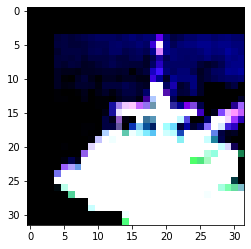

In [ ]:
# To view an example image:
#plt.imshow(next(iter(train_dl))[0][0].permute(1,2,0))
#plt.show()

# Define and train ResNets
If `SAVE_MODELS` is enabled, the models are saved in the local storage (or Google Drive if `USE_GOOGLE_DRIVE` is enabled) when they are trained.

Likewise, they can be loaded from the local storage (or Google Drive if `USE_GOOGLE_DRIVE` is enabled) with `LOAD_MODELS`.

In [ ]:
def train_models(train_dl, class_cnt, weights, device=device,
                epoch_cnt=EPOCH_CNT, multi_gpu=MULTI_GPU, dataset=DATASET,
                resnet_type=RESNET_TYPE, print_training=PRINT_TRAINING,
                print_freq=PRINT_FREQ, draw_plots=DRAW_PLOTS,
                use_gdrive=USE_GOOGLE_DRIVE, models_path=MODELS_PATH,
                save_models=SAVE_MODELS, load_models=LOAD_MODELS,
                train_focal=TRAIN_FOCAL, train_sigmoid=TRAIN_SIGMOID,
                train_softmax=TRAIN_SOFTMAX, train_cb_focal=TRAIN_CB_FOCAL,
                train_cb_sigmoid=TRAIN_CB_SIGMOID,
                train_cb_softmax=TRAIN_CB_SOFTMAX, test_focal=test_focal,
                test_sigmoid=TEST_SIGMOID, test_softmax=TEST_SOFTMAX,
                test_cb_focal=TEST_CB_FOCAL, test_cb_sigmoid=TEST_CB_SIGMOID,
                test_cb_softmax=TEST_CB_SOFTMAX):
  if resnet_type == "32":
    rn = ResNet32
  elif resnet_type == "50":
    rn = models.resnet50
  elif resnet_type == "101":
    rn = models.resnet101
  elif resnet_type == "152":
    rn = models.resnet152
  else:
    raise ValueError("Invalid resnet_type")

  param_list = []

  rn_focal = None
  rn_sigmoid = None
  rn_softmax = None
  rn_cb_focal = None
  rn_cb_sigmoid = None
  rn_cb_softmax = None

  # The "state" var. provides the same initial state for every model
  state = None

  if train_focal: 
    rn_focal = rn(num_classes=class_cnt).double()
    if multi_gpu: rn_focal = nn.DataParallel(rn_focal)
    rn_focal = rn_focal.to(device)

    param_list.append({'params': rn_focal.parameters()})

    state = rn_focal.state_dict()
  if train_sigmoid: 
    rn_sigmoid = rn(num_classes=class_cnt).double()
    if multi_gpu: rn_sigmoid = nn.DataParallel(rn_sigmoid)
    rn_sigmoid = rn_sigmoid.to(device)

    param_list.append({'params': rn_sigmoid.parameters()})

    if state:
      rn_sigmoid.load_state_dict(state)
    else:
      state = rn_sigmoid.state_dict()
  if train_softmax:
    rn_softmax = rn(num_classes=class_cnt).double()
    if multi_gpu: rn_softmax = nn.DataParallel(rn_softmax)
    rn_softmax = rn_softmax.to(device)

    param_list.append({'params': rn_softmax.parameters()})

    if state:
      rn_softmax.load_state_dict(state)
    else:
      state = rn_softmax.state_dict()
  if train_cb_focal:
    rn_cb_focal = rn(num_classes=class_cnt).double()
    if multi_gpu: rn_cb_focal = nn.DataParallel(rn_cb_focal)
    rn_cb_focal = rn_cb_focal.to(device)

    param_list.append({'params': rn_cb_focal.parameters()})

    if state:
      rn_cb_focal.load_state_dict(state)
    else:
      state = rn_cb_focal.state_dict()
  if train_cb_sigmoid:
    rn_cb_sigmoid = rn(num_classes=class_cnt).double()
    if multi_gpu: rn_cb_sigmoid = nn.DataParallel(rn_cb_sigmoid)
    rn_cb_sigmoid = rn_cb_sigmoid.to(device)

    param_list.append({'params': rn_cb_sigmoid.parameters()})

    if state:
      rn_cb_sigmoid.load_state_dict(state)
    else:
      state = rn_cb_sigmoid.state_dict()
  if train_cb_softmax:
    rn_cb_softmax = rn(num_classes=class_cnt).double()
    if multi_gpu: rn_cb_softmax = nn.DataParallel(rn_cb_softmax)
    rn_cb_softmax = rn_cb_softmax.to(device)

    param_list.append({'params': rn_cb_softmax.parameters()})

    if state:
      rn_cb_softmax.load_state_dict(state)

  if load_models:
    # Assuming the file exists for each model that will be tested:
    # TODO: Catch loading errors in try-except blocks

    if test_focal:
      rn_focal.load_state_dict(
        torch.load(models_path + f"rn{resnet_type}_focal_{dataset}.pth",
                   map_location=device)
      )
      print(f"Loaded model (ResNet-{resnet_type} focal, {DSET_NAMES[dataset]}):",
            models_path + f"rn{resnet_type}_focal_{dataset}.pth")
    
    if test_sigmoid:
      rn_sigmoid.load_state_dict(
        torch.load(models_path + f"rn{resnet_type}_sigmoid_{dataset}.pth",
                   map_location=device)
      )
      print(f"Loaded model (ResNet-{resnet_type} sigmoid, {DSET_NAMES[dataset]}):",
            models_path + f"rn{resnet_type}_sigmoid_{dataset}.pth")

    if test_softmax:
      rn_softmax.load_state_dict(
        torch.load(models_path + f"rn{resnet_type}_softmax_{dataset}.pth",
                   map_location=device)
      )
      print(f"Loaded model (ResNet-{resnet_type} softmax, {DSET_NAMES[dataset]}):",
            models_path + f"rn{resnet_type}_softmax_{dataset}.pth")

    if test_cb_focal:
      rn_cb_focal.load_state_dict(
        torch.load(models_path + f"rn{resnet_type}_cb_focal_{dataset}.pth",
                   map_location=device)
      )
      print(f"Loaded model (ResNet-{resnet_type} cb. focal, {DSET_NAMES[dataset]}):",
            models_path + f"rn{resnet_type}_cb_focal_{dataset}.pth")

    if test_cb_sigmoid:
      rn_cb_sigmoid.load_state_dict(
        torch.load(models_path + f"rn{resnet_type}_cb_sigmoid_{dataset}.pth",
                   map_location=device)
      )
      print(f"Loaded model (ResNet-{resnet_type} cb. sigmoid, {DSET_NAMES[dataset]}):",
            models_path + f"rn{resnet_type}_cb_sigmoid_{dataset}.pth")

    if test_cb_softmax:
      rn_cb_softmax.load_state_dict(
        torch.load(models_path + f"rn{resnet_type}_cb_softmax_{dataset}.pth",
                   map_location=device)
      )
      print(f"Loaded model (ResNet-{resnet_type} cb. softmax, {DSET_NAMES[dataset]}):",
            models_path + f"rn{resnet_type}_cb_softmax_{dataset}.pth")
  else:
    # Initialize FC biases of models trained with sigmoid and focal losses
    #   to avoid instability at the beginning of the training
    pi = torch.tensor(0.1, dtype=torch.double)
    b = -torch.log((1 - pi) / pi)
    
    if multi_gpu:
      if train_focal: rn_focal.module.fc.bias.data.fill_(b)
      if train_sigmoid: rn_sigmoid.module.fc.bias.data.fill_(b)
      if train_cb_focal: rn_cb_focal.module.fc.bias.data.fill_(b)
      if train_cb_sigmoid: rn_cb_sigmoid.module.fc.bias.data.fill_(b)
    else:
      if train_focal: rn_focal.fc.bias.data.fill_(b)
      if train_sigmoid: rn_sigmoid.fc.bias.data.fill_(b)
      if train_cb_focal: rn_cb_focal.fc.bias.data.fill_(b)
      if train_cb_sigmoid: rn_cb_sigmoid.fc.bias.data.fill_(b)

    # TODO: Disable optimizer's weight decay for the biases
    #rn_focal.fc.bias.requires_grad_(False)
    #rn_sigmoid.fc.bias.requires_grad_(False)
    #rn_cb_focal.fc.bias.requires_grad_(False)
    #rn_cb_sigmoid.fc.bias.requires_grad_(False)

    # Initialize ce. loss models' FC biases with 0
    if multi_gpu:
      if train_softmax: rn_softmax.module.fc.bias.data.fill_(0)
      if train_cb_softmax: rn_cb_softmax.module.fc.bias.data.fill_(0)
    else:
      if train_softmax: rn_softmax.fc.bias.data.fill_(0)
      if train_cb_softmax: rn_cb_softmax.fc.bias.data.fill_(0)
    
    optimizer = torch.optim.SGD(
      param_list,
      lr=0,  # Will be graudally increased to 0.1 in 5 epochs
      momentum=0.9,
      weight_decay=2e-4
    )

    if train_softmax: cel = nn.CrossEntropyLoss()
    if train_cb_softmax: 
      #print("Passing weights:", weights)
      cb_cel = nn.CrossEntropyLoss(weight=weights, reduction="sum")

    if draw_plots:
      if train_focal: history_loss_focal = []
      if train_sigmoid: history_loss_sigmoid = []
      if train_softmax: history_loss_softmax = []
      if train_cb_focal: history_loss_cb_focal = []
      if train_cb_sigmoid: history_loss_cb_sigmoid = []
      if train_cb_softmax: history_loss_cb_softmax = []

    print(f"Starting training with {DSET_NAMES[dataset]} dataset,",
      f"ResNet-{resnet_type} models.")
    try:
      for epoch in range(epoch_cnt):
        if train_focal: total_loss_focal = 0
        if train_sigmoid: total_loss_sigmoid = 0
        if train_softmax: total_loss_softmax = 0
        if train_cb_focal: total_loss_cb_focal = 0
        if train_cb_sigmoid: total_loss_cb_sigmoid = 0
        if train_cb_softmax: total_loss_cb_softmax = 0
        
        if epoch < 5:
          # Linear warm-up of learning rate from 0 to 0.1 in the first 5 epochs
          for g in optimizer.param_groups:
            g["lr"] += 0.02
        elif epoch in [159, 179]:
          # Decay learning rate by 0.01 at 160th and 180th epochs
          for g in optimizer.param_groups:
            g["lr"] *= 0.01

        for i, (input, target) in enumerate(train_dl):
          input = input.double().to(device)
          target = target.to(device)

          optimizer.zero_grad()

          if train_focal:
            loss_focal = focal_loss(
                rn_focal(input),
                target,
                gamma=0.5
            )

            loss_focal.backward()
            total_loss_focal += loss_focal.item()
          
          if train_sigmoid:
            loss_sigmoid = focal_loss(
                rn_sigmoid(input),
                target
            )

            loss_sigmoid.backward()
            total_loss_sigmoid += loss_sigmoid.item()

          if train_softmax:
            loss_softmax = cel(
                rn_softmax(input),
                target
            )
            
            loss_softmax.backward()
            total_loss_softmax += loss_softmax.item()

          if train_cb_focal:
            loss_cb_focal = focal_loss(
                rn_cb_focal(input),
                target,
                alpha=weights,
                gamma=0.5
            )

            loss_cb_focal.backward()
            total_loss_cb_focal += loss_cb_focal.item()

          if train_cb_sigmoid:
            loss_cb_sigmoid = focal_loss(
                rn_cb_sigmoid(input),
                target,
                alpha=weights
            )

            loss_cb_sigmoid.backward()
            total_loss_cb_sigmoid += loss_cb_sigmoid.item()

          if train_cb_softmax:
            loss_cb_softmax = cb_cel(
                rn_cb_softmax(input),
                target
            ) / target.shape[0]
            
            loss_cb_softmax.backward()
            total_loss_cb_softmax += loss_cb_softmax.item()

          optimizer.step()

          if print_training and \
            ((epoch == 0 and i == 0) or (i % print_freq == (print_freq - 1))):
            print("Epoch:", epoch, "| Batch:", str(i + 1))

            if train_focal:
              print("Focal:".rjust(11), total_loss_focal/(i+1))
            if train_sigmoid:
              print("Sigmoid:".rjust(11), total_loss_sigmoid/(i+1))
            if train_softmax:
              print("Softmax:".rjust(11), total_loss_softmax/(i+1))
            if train_cb_focal:
              print("CB Focal:".rjust(11), total_loss_cb_focal/(i+1))
            if train_cb_sigmoid:
              print("CB Sigmoid:", total_loss_cb_sigmoid/(i+1))
            if train_cb_softmax:
              print("CB Softmax:", total_loss_cb_softmax/(i+1))
            
            print()  # Print empty line
        else:  # The end of each epoch
          if save_models:  # Temporary backup for each epoch
            # Delete all temporary files under temp/epoch_end/
            for f in os.listdir(models_path + "temp/epoch_end/"):
              fpath = models_path + "temp/epoch_end/" + f
              os.remove(fpath)
              #print("Removed:", fpath)

            if train_focal:
              torch.save(
                  rn_focal.state_dict(),
                  models_path + f"temp/epoch_end/rn{resnet_type}_focal_{dataset}_epoch{epoch}_batch{i+1}.pth"
              )
              #print(f"Saved model (ResNet-{resnet_type} focal, {DSET_NAMES[dataset]}):",
              #      models_path + f"temp/epoch_end/rn{resnet_type}_focal_{dataset}_epoch{epoch}_batch{i+1}.pth")

            if train_sigmoid:
              torch.save(
                  rn_sigmoid.state_dict(),
                  models_path + f"temp/epoch_end/rn{resnet_type}_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth"
              )
              #print(f"Saved model (ResNet-{resnet_type} sigmoid, {DSET_NAMES[dataset]}):",
              #      models_path + f"temp/epoch_end/rn{resnet_type}_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth")

            if train_softmax:
              torch.save(
                  rn_softmax.state_dict(),
                  models_path + f"temp/epoch_end/rn{resnet_type}_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth"
              )
              #print(f"Saved model (ResNet-{resnet_type} softmax, {DSET_NAMES[dataset]}):",
              #      models_path + f"temp/epoch_end/rn{resnet_type}_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth")
            
            if train_cb_focal:
              torch.save(
                  rn_cb_focal.state_dict(),
                  models_path + f"temp/epoch_end/rn{resnet_type}_cb_focal_{dataset}_epoch{epoch}_batch{i+1}.pth"
              )
              #print(f"Saved model (ResNet-{resnet_type} cb. focal, {DSET_NAMES[dataset]}):",
              #      models_path + f"temp/epoch_end/rn{resnet_type}_cb_focal_{dataset}_epoch{epoch}_batch{i+1}.pth")
            
            if train_cb_sigmoid:
              torch.save(
                  rn_cb_sigmoid.state_dict(),
                  models_path + f"temp/epoch_end/rn{resnet_type}_cb_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth"
              )
              #print(f"Saved model (ResNet-{resnet_type} cb. sigmoid, {DSET_NAMES[dataset]}):",
              #      models_path + f"temp/epoch_end/rn{resnet_type}_cb_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth")
            
            if train_cb_softmax:
              torch.save(
                  rn_cb_softmax.state_dict(),
                  models_path + f"temp/epoch_end/rn{resnet_type}_cb_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth"
              )
              #print(f"Saved model (ResNet-{resnet_type} cb. softmax, {DSET_NAMES[dataset]}):",
              #      models_path + f"temp/epoch_end/rn{resnet_type}_cb_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth")
          
          if draw_plots:
            if train_focal:
              history_loss_focal.append(total_loss_focal/(i+1))
            if train_sigmoid:
              history_loss_sigmoid.append(total_loss_sigmoid/(i+1))
            if train_softmax:
              history_loss_softmax.append(total_loss_softmax/(i+1))
            if train_cb_focal:
              history_loss_cb_focal.append(total_loss_cb_focal/(i+1))
            if train_cb_sigmoid:
              history_loss_cb_sigmoid.append(total_loss_cb_sigmoid/(i+1))
            if train_cb_softmax:
              history_loss_cb_softmax.append(total_loss_cb_softmax/(i+1))

          if print_training:
            print("Epoch:", epoch, "| Batch:", str(i + 1))

            if train_focal:
              print("Focal:".rjust(11), total_loss_focal/(i+1))
            if train_sigmoid:
              print("Sigmoid:".rjust(11), total_loss_sigmoid/(i+1))
            if train_softmax:
              print("Softmax:".rjust(11), total_loss_softmax/(i+1))
            if train_cb_focal:
              print("CB Focal:".rjust(11), total_loss_cb_focal/(i+1))
            if train_cb_sigmoid:
              print("CB Sigmoid:", total_loss_cb_sigmoid/(i+1))
            if train_cb_softmax:
              print("CB Softmax:", total_loss_cb_softmax/(i+1))
            
            print()  # Print empty line
    except KeyboardInterrupt:
      print("Got KeyboardInterrupt.")

      if save_models:
        print("Deleting previous backups.")
        # Delete all temporary files under temp/interrupted/
        for f in os.listdir(models_path + "temp/interrupted/"):
          fpath = models_path + "temp/interrupted/" + f
          os.remove(fpath)
          print("Removed:", fpath)
        
        print("Backing up the models.")

        if train_focal:
          torch.save(
              rn_focal.state_dict(),
              models_path + f"temp/interrupted/rn{resnet_type}_focal_{dataset}_epoch{epoch}_batch{i+1}.pth"
          )
          print(f"Saved model (ResNet-{resnet_type} focal, {DSET_NAMES[dataset]}):",
                models_path + f"temp/interrupted/rn{resnet_type}_focal_{dataset}_epoch{epoch}_batch{i+1}.pth")

        if train_sigmoid:
          torch.save(
              rn_sigmoid.state_dict(),
              models_path + f"temp/interrupted/rn{resnet_type}_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth"
          )
          print(f"Saved model (ResNet-{resnet_type} sigmoid, {DSET_NAMES[dataset]}):",
                models_path + f"temp/interrupted/rn{resnet_type}_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth")

        if train_softmax:
          torch.save(
              rn_softmax.state_dict(),
              models_path + f"temp/interrupted/rn{resnet_type}_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth"
          )
          print(f"Saved model (ResNet-{resnet_type} softmax, {DSET_NAMES[dataset]}):",
                models_path + f"temp/interrupted/rn{resnet_type}_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth")
        
        if train_cb_focal:
          torch.save(
              rn_cb_focal.state_dict(),
              models_path + f"temp/interrupted/rn{resnet_type}_cb_focal_{dataset}_epoch{epoch}_batch{i+1}.pth"
          )
          print(f"Saved model (ResNet-{resnet_type} cb. focal, {DSET_NAMES[dataset]}):",
                models_path + f"temp/interrupted/rn{resnet_type}_cb_focal_{dataset}_epoch{epoch}_batch{i+1}.pth")
        
        if train_cb_sigmoid:
          torch.save(
              rn_cb_sigmoid.state_dict(),
              models_path + f"temp/interrupted/rn{resnet_type}_cb_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth"
          )
          print(f"Saved model (ResNet-{resnet_type} cb. sigmoid, {DSET_NAMES[dataset]}):",
                models_path + f"temp/interrupted/rn{resnet_type}_cb_sigmoid_{dataset}_epoch{epoch}_batch{i+1}.pth")
        
        if train_cb_softmax:
          torch.save(
              rn_cb_softmax.state_dict(),
              models_path + f"temp/interrupted/rn{resnet_type}_cb_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth"
          )
          print(f"Saved model (ResNet-{resnet_type} cb. softmax, {DSET_NAMES[dataset]}):",
                models_path + f"temp/interrupted/rn{resnet_type}_cb_softmax_{dataset}_epoch{epoch}_batch{i+1}.pth")
      
      print("Terminating.")
      sys.exit(1)
    
  
    # Save the trained models

    if save_models:
      if train_focal:
        torch.save(
            rn_focal.state_dict(),
            models_path + f"rn{resnet_type}_focal_{dataset}.pth"
        )
        print(f"Saved model (ResNet-{resnet_type} focal, {DSET_NAMES[dataset]}):",
              models_path + f"rn{resnet_type}_focal_{dataset}.pth")

      if train_sigmoid:
        torch.save(
            rn_sigmoid.state_dict(),
            models_path + f"rn{resnet_type}_sigmoid_{dataset}.pth"
        )
        print(f"Saved model (ResNet-{resnet_type} sigmoid, {DSET_NAMES[dataset]}):",
              models_path + f"rn{resnet_type}_sigmoid_{dataset}.pth")

      if train_softmax:
        torch.save(
            rn_softmax.state_dict(),
            models_path + f"rn{resnet_type}_softmax_{dataset}.pth"
        )
        print(f"Saved model (ResNet-{resnet_type} softmax, {DSET_NAMES[dataset]}):",
              models_path + f"rn{resnet_type}_softmax_{dataset}.pth")
      
      if train_cb_focal:
        torch.save(
            rn_cb_focal.state_dict(),
            models_path + f"rn{resnet_type}_cb_focal_{dataset}.pth"
        )
        print(f"Saved model (ResNet-{resnet_type} cb. focal, {DSET_NAMES[dataset]}):",
              models_path + f"rn{resnet_type}_cb_focal_{dataset}.pth")
      
      if train_cb_sigmoid:
        torch.save(
            rn_cb_sigmoid.state_dict(),
            models_path + f"rn{resnet_type}_cb_sigmoid_{dataset}.pth"
        )
        print(f"Saved model (ResNet-{resnet_type} cb. sigmoid, {DSET_NAMES[dataset]}):",
              models_path + f"rn{resnet_type}_cb_sigmoid_{dataset}.pth")
      
      if train_cb_softmax:
        torch.save(
            rn_cb_softmax.state_dict(),
            models_path + f"rn{resnet_type}_cb_softmax_{dataset}.pth"
        )
        print(f"Saved model (ResNet-{resnet_type} cb. softmax, {DSET_NAMES[dataset]}):",
              models_path + f"rn{resnet_type}_cb_softmax_{dataset}.pth")
    
    if draw_plots:
      legend = []
      plt.figure(figsize=(16, 12))

      if train_focal:
        plt.plot(history_loss_focal, "-b")
        legend.append("Focal Loss")
      if train_sigmoid:
        plt.plot(history_loss_sigmoid, "-r")
        legend.append("Sigmoid CE Loss")
      if train_softmax:
        plt.plot(history_loss_softmax, "-g")
        legend.append("CE Loss")
      if train_cb_focal:
        plt.plot(history_loss_cb_focal, "-c")
        legend.append("Class-Balanced Focal Loss")
      if train_cb_sigmoid:
        plt.plot(history_loss_cb_sigmoid, "-m")
        legend.append("Class-Balanced Sigmoid CE Loss")
      if train_cb_softmax:
        plt.plot(history_loss_cb_softmax, "-y")
        legend.append("Class-Balanced CE Loss")
      
      if legend:
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(legend)
        plt.title(
          f"Loss vs. Epochs on {DSET_NAMES[dataset]} with ResNet-{resnet_type}"
        )

        if not use_gdrive: 
          plt.savefig(
            f"./plots/{dataset.lower()}_rn-{resnet_type}-losses.png"
          )
        
        plt.show()
  
  return (rn_focal, rn_sigmoid, rn_softmax, rn_cb_focal, rn_cb_sigmoid,
          rn_cb_softmax)


if __name__ == "__main__":
  models = train_models(train_dl, class_cnt, weights)


# Test the accuracy:

ResNet with unweighted focal loss:
    Average top-1 accuracy: tensor(0.4478)
  Top-1 Accuracy per class: tensor([0.9910, 0.9450, 0.7180, 0.5150, 0.5200, 0.3170, 0.2710, 0.1370, 0.0520,
        0.0120])


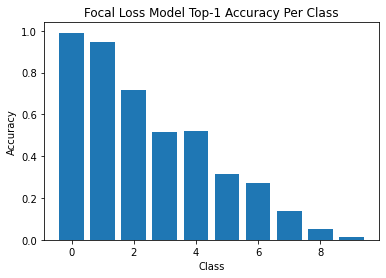

ResNet with unweighted sigmoid loss:
    Average top-1 accuracy: tensor(0.4537)
  Top-1 Accuracy per class: tensor([0.9920, 0.9520, 0.7180, 0.5160, 0.5520, 0.3080, 0.2760, 0.1640, 0.0470,
        0.0120])


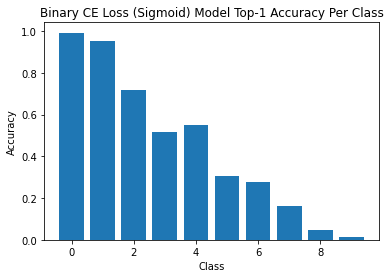

ResNet with unweighted softmax loss:
    Average top-1 accuracy: tensor(0.4670)
  Top-1 Accuracy per class: tensor([0.9840, 0.9410, 0.7270, 0.5350, 0.5530, 0.3250, 0.3290, 0.1880, 0.0600,
        0.0280])


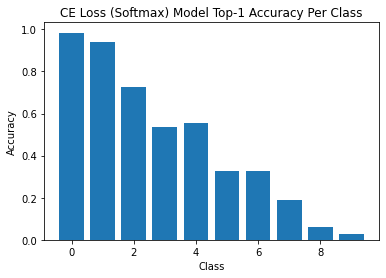

ResNet with class-balanced focal loss:
    Average top-1 accuracy: tensor(0.5037)
  Top-1 Accuracy per class: tensor([0.8830, 0.8670, 0.5040, 0.3670, 0.4630, 0.3540, 0.4930, 0.3840, 0.3670,
        0.3550])


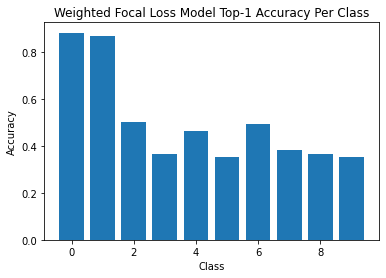

ResNet with class-balanced sigmoid loss:
    Average top-1 accuracy: tensor(0.4715)
  Top-1 Accuracy per class: tensor([0.8660, 0.8240, 0.4670, 0.2990, 0.4530, 0.3110, 0.4590, 0.3180, 0.3660,
        0.3520])


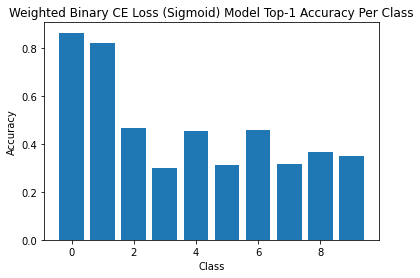

ResNet with class-balanced softmax loss:
    Average top-1 accuracy: tensor(0.4703)
  Top-1 Accuracy per class: tensor([0.8480, 0.8280, 0.4670, 0.3690, 0.4890, 0.2700, 0.4980, 0.3640, 0.3740,
        0.1960])


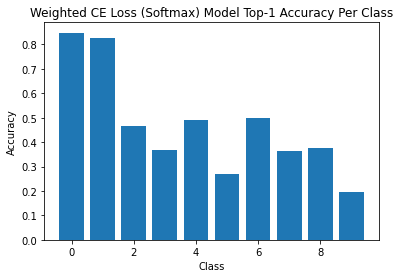

In [ ]:
def acc_results(models, test_dl, test_class_sizes, calc_avg=True, 
                calc_perclass=True, top=ACCURACY_TOP, dataset=DATASET,
                resnet_type=RESNET_TYPE, draw_plots=DRAW_PLOTS,
                use_gdrive=USE_GOOGLE_DRIVE, test_focal=TEST_FOCAL,
                test_sigmoid=TEST_SIGMOID, test_softmax=TEST_SOFTMAX,
                test_cb_focal=TEST_CB_FOCAL, test_cb_sigmoid=TEST_CB_SIGMOID,
                test_cb_softmax=TEST_CB_SOFTMAX):
  results = [None] * 6
  
  if not (calc_avg or calc_perclass): return results

  if test_focal:
    avg, pc = get_accuracy(test_dl, models[0].eval(), test_class_sizes, 
                           calc_avg=calc_avg, calc_perclass=calc_perclass, 
                           top=top)

    results[0] = (avg, pc)

    print("ResNet with unweighted focal loss:")
    if calc_avg: print(f"    Average top-{top} accuracy:", avg)
    if calc_perclass: print(f"  Top-{top} Accuracy per class:", pc)

    if draw_plots:
      plt.figure(figsize=(16, 12))
      plt.bar(np.arange(10), pc.tolist())
      plt.xlabel("Class")
      plt.ylabel("Accuracy")
      plt.title(f"Focal Loss Model Top-{top} Accuracy Per Class")

      if not use_gdrive:
        plt.savefig(
          f"./plots/{dataset.lower()}_rn-{resnet_type}_focal_accuracy.png"
        )
      
      plt.show()
      
  if test_sigmoid:
    avg, pc = get_accuracy(test_dl, models[1].eval(), test_class_sizes, 
                           calc_avg=calc_avg, calc_perclass=calc_perclass,
                           top=top)

    results[1] = (avg, pc)

    print("ResNet with unweighted sigmoid loss:")
    if calc_avg: print(f"    Average top-{top} accuracy:", avg)
    if calc_perclass: print(f"  Top-{top} Accuracy per class:", pc)

    if draw_plots:
      plt.figure(figsize=(16, 12))
      plt.bar(np.arange(10), pc.tolist())
      plt.xlabel("Class")
      plt.ylabel("Accuracy")
      plt.title(f"Binary CE Loss (Sigmoid) Model Top-{top} Accuracy Per Class")

      if not use_gdrive: 
        plt.savefig(
          f"./plots/{dataset.lower()}_rn-{resnet_type}_sigmoid_accuracy.png"
        )
      
      plt.show()
  
  if test_softmax:
    avg, pc = get_accuracy(test_dl, models[2].eval(), test_class_sizes,
                           calc_avg=calc_avg, calc_perclass=calc_perclass, 
                           top=top)

    results[2] = (avg, pc)

    print("ResNet with unweighted softmax loss:")
    if calc_avg: print(f"    Average top-{top} accuracy:", avg)
    if calc_perclass: print(f"  Top-{top} Accuracy per class:", pc)

    if draw_plots:
      plt.figure(figsize=(16, 12))
      plt.bar(np.arange(10), pc.tolist())
      plt.xlabel("Class")
      plt.ylabel("Accuracy")
      plt.title(f"CE Loss (Softmax) Model Top-{top} Accuracy Per Class")

      if not use_gdrive: 
        plt.savefig(
          f"./plots/{dataset.lower()}_rn-{resnet_type}_softmax_accuracy.png"
        )
      
      plt.show()
  
  if test_cb_focal:
    avg, pc = get_accuracy(test_dl, models[3].eval(), test_class_sizes, 
                           calc_avg=calc_avg, calc_perclass=calc_perclass, 
                           top=top)

    results[3] = (avg, pc)

    print("ResNet with class-balanced focal loss:")
    if calc_avg: print(f"    Average top-{top} accuracy:", avg)
    if calc_perclass: print(f"  Top-{top} Accuracy per class:", pc)

    if draw_plots:
      plt.figure(figsize=(16, 12))
      plt.bar(np.arange(10), pc.tolist())
      plt.xlabel("Class")
      plt.ylabel("Accuracy")
      plt.title(f"Weighted Focal Loss Model Top-{top} Accuracy Per Class")

      if not use_gdrive: 
        plt.savefig(
          f"./plots/{dataset.lower()}_rn-{resnet_type}_cb_focal_accuracy.png"
        )
      
      plt.show()
  
  if test_cb_sigmoid:
    avg, pc = get_accuracy(test_dl, models[4].eval(), test_class_sizes, 
                           calc_avg=calc_avg, calc_perclass=calc_perclass, 
                           top=top)

    results[4] = (avg, pc)

    print("ResNet with class-balanced sigmoid loss:")
    if calc_avg: print(f"    Average top-{top} accuracy:", avg)
    if calc_perclass: print(f"  Top-{top} Accuracy per class:", pc)

    if draw_plots:
      plt.figure(figsize=(16, 12))
      plt.bar(np.arange(10), pc.tolist())
      plt.xlabel("Class")
      plt.ylabel("Accuracy")
      plt.title(f"Weighted Binary CE Loss (Sigmoid) Model Top-{top} Accuracy Per Class")

      if not use_gdrive: 
        plt.savefig(
          f"./plots/{dataset.lower()}_rn-{resnet_type}_cb_sigmoid_accuracy.png"
        )
      
      plt.show()
  
  if test_cb_softmax:
    avg, pc = get_accuracy(test_dl, models[5].eval(), test_class_sizes,
                           calc_avg=calc_avg, calc_perclass=calc_perclass,
                           top=top)

    results[5] = (avg, pc)

    print("ResNet with class-balanced softmax loss:")
    if calc_avg: print(f"    Average top-{top} accuracy:", avg)
    if calc_perclass: print(f"  Top-{top} Accuracy per class:", pc)

    if draw_plots:
      plt.figure(figsize=(16, 12))
      plt.bar(np.arange(10), pc)
      plt.xlabel("Class")
      plt.ylabel("Accuracy")
      plt.title(f"Weighted CE Loss (Softmax) Model Top-{top} Accuracy Per Class")

      if not use_gdrive: 
        plt.savefig(
          f"./plots/{dataset.lower()}_rn-{resnet_type}_cb_softmax_accuracy.png"
        )
      
      plt.show()

  return results


if __name__ == "__main__":
  acc_results(models, test_dl, test_class_sizes)